<a href="https://colab.research.google.com/github/Timmmtech/Pytorch-Basics/blob/main/Pytorch_project_LinearReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import TensorDataset, DataLoader, random_split


In [ ]:
batch_size=64
learning_rate=5e-7

DATASET_URL = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
DATA_FILENAME = "BostonHousing.csv"
TARGET_COLUMN = 'medv'
input_size=13
output_size=1

In [ ]:
## Download the dataset
download_url(DATASET_URL, '.')
data = pd.read_csv(DATA_FILENAME)
data.head()


100%|██████████| 35.7k/35.7k [00:00<00:00, 7.93MB/s]


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
data = pd.read_csv(DATA_FILENAME)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
## Define the input and output dataset
inputs = data.drop('medv', axis=1).values
targets = data[['medv']].values
inputs.shape, targets.shape

((506, 13), (506, 1))

In [ ]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32),
                        torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [406, 100])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

In [ ]:
class HousingModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, output_size)

  def forward(self, xb):
    out = self.linear(xb)
    return out

  def training_step(self, batch):
    inputs, targets = batch
    out = self(inputs)  ## Generate pred
    loss = F.mse_loss(out, targets)  ## Cal loss
    return loss

  def validation_step(self, batch):
    inputs, targets = batch
    out = self(inputs)
    loss = F.mse_loss(out, targets)
    return {'val_loss': loss.detach()}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()  ## Combine losses
    return {'val_loss': epoch_loss.item()}

  def epoch_end(self, epoch, result):
    print(f"Epoch [{epoch + 1}] -> val_loss: {result['val_loss']:.4f}")

model = HousingModel()


In [ ]:
## Training

def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)

  for epoch in range(epochs):
    ## Training
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      ## Validation
      result = evaluate(model, val_loader)
      model.epoch_end(epoch, result)
      history.append(result)
    return history

In [ ]:
result = evaluate(model, val_loader)
result

{'val_loss': 1221.72998046875}

In [ ]:
history = fit(100, learning_rate, model, train_loader, val_loader)

Epoch [1] -> val_loss: 75.7493
Epoch [1] -> val_loss: 76.0642
Epoch [1] -> val_loss: 75.9155
Epoch [1] -> val_loss: 74.8443
Epoch [1] -> val_loss: 74.6951
Epoch [1] -> val_loss: 74.9508
Epoch [1] -> val_loss: 75.9776


Text(0.5, 1.0, 'val_loss vs. epochs')

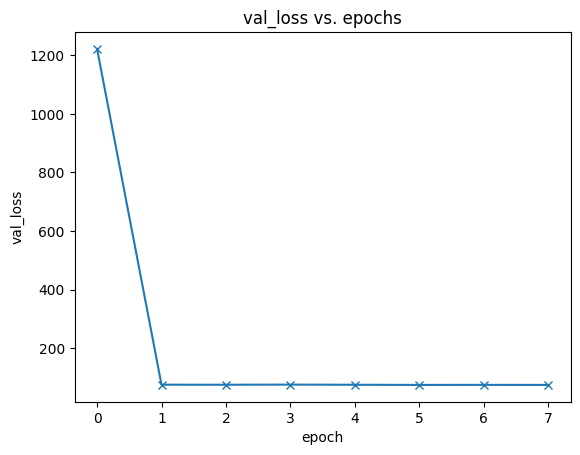

In [ ]:
losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs')

In [ ]:
# Prediction
def predict_single(x, model):
     xb = x.unsqueeze(0)
     return model(xb).item()

In [ ]:
x, target = val_ds[12]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([  4.7524,   0.0000,  18.1000,   0.0000,   0.7130,   6.5250,  86.5000,
          2.4358,  24.0000, 666.0000,  20.2000,  50.9200,  18.1300])
Target:  14.100000381469727
Prediction: 7.870241641998291
